# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch
import sys

sys.path.append('/global/u2/q/qingyanz/cgcnn')

# Find and use the appropriate GPU/CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed data from the caches that we generated with the `../preprocessing/create_sdt.py` and `../preprocessing/split_data.ipynb` files.

In [2]:
import pickle

# Load the data split from our Jupyter notebook cache
with open('../preprocessing/sdt/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']

# Train

In [3]:
import numpy as np
from sklearn.model_selection import KFold
from torch.optim import Adam
import skorch.callbacks.base
from skorch.callbacks import Checkpoint  # needs skorch >= 0.4
from skorch.callbacks.lr_scheduler import LRScheduler
from skorch import NeuralNetRegressor
from cgcnn.dropoutmodel20 import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./histories/%i_valid_best_params.pt' % k)

nets = []
# Fold the CV data
k_folder = KFold(n_splits=5)
for k, (indices_train, _) in enumerate(k_folder.split(sdts_train)):
    stds_train_ = [sdts_train[index] for index in indices_train]
    targets_train_ = np.array([targets_train[index] for index in indices_train])

    # Define various callbacks and checkpointers for this network
    LR_schedule = LRScheduler('MultiStepLR', milestones=[75], gamma=0.1)
    cp = Checkpoint(monitor='valid_loss_best', fn_prefix='./histories/%i_valid_best_' % k)
    load_best_valid_loss = train_end_load_best_valid_loss()

    # Train this fold's network
    net = NeuralNetRegressor(
        CrystalGraphConvNet,
        module__orig_atom_fea_len=orig_atom_fea_len,
        module__nbr_fea_len=nbr_fea_len,
        batch_size=214,
        module__classification=False,
        lr=0.0056,
        max_epochs=100,
        module__atom_fea_len=46,
        module__h_fea_len=83,
        module__n_conv=8,
        module__n_h=4,
        optimizer=Adam,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=0,
        iterator_train__collate_fn=collate_pool,
        iterator_train__shuffle=True,
        iterator_valid__pin_memory=True,
        iterator_valid__num_workers=0,
        iterator_valid__collate_fn=collate_pool,
        iterator_valid__shuffle=False,
        device=device,
        criterion=torch.nn.L1Loss,
        dataset=MergeDataset,
        callbacks=[cp, load_best_valid_loss, LR_schedule]
    )
    net.initialize()
    net.fit(stds_train_, targets_train_)
    nets.append(net)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.4572        0.4832     +  19.4035
      2        0.3464        0.4330     +  16.4921
      3        0.2995        0.3586     +  16.4730
      4        0.2926        0.3326     +  16.5412
      5        0.2953        0.3225     +  16.5594
      6        0.2999        0.3255        16.4636
      7        0.2939        0.3044     +  16.5367
      8        0.2635        0.3085        16.4812
      9        0.2410        0.3248        16.5095
     10        0.2374        0.3131        16.4991
     11        0.2459        0.3416        16.5183
     12        0.2549        0.2954     +  16.6317
     14        0.2321        0.2872     +  16.6780
     15        0.2265        0.2943        16.4764
  

# Loading models
It takes a few hours to fit the 5-model ensemble. You can either do it via notebook (above) or via `sbatch submit_ensemble_fitting.sh`. Either way, you load the results here.

In [4]:
import numpy as np
from sklearn.model_selection import KFold
from torch.optim import Adam
import skorch.callbacks.base
from skorch.callbacks import Checkpoint  # needs skorch >= 0.4
from skorch.callbacks.lr_scheduler import LRScheduler
from skorch import NeuralNetRegressor
from cgcnn.dropoutmodel20 import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./histories/%i_valid_best_params.pt' % k)

nets = []
# Fold the CV data
k_folder = KFold(n_splits=5)
for k, (indices_train, _) in enumerate(k_folder.split(sdts_train)):
    stds_train_ = [sdts_train[index] for index in indices_train]
    targets_train_ = np.array([targets_train[index] for index in indices_train])

    # Define various callbacks and checkpointers for this network
    LR_schedule = LRScheduler('MultiStepLR', milestones=[75], gamma=0.1)
    cp = Checkpoint(monitor='valid_loss_best', fn_prefix='./histories/%i_valid_best_' % k)
    load_best_valid_loss = train_end_load_best_valid_loss()

    # Train this fold's network
    net = NeuralNetRegressor(
        CrystalGraphConvNet,
        module__orig_atom_fea_len=orig_atom_fea_len,
        module__nbr_fea_len=nbr_fea_len,
        batch_size=214,
        module__classification=False,
        lr=0.0056,
        max_epochs=100,
        module__atom_fea_len=46,
        module__h_fea_len=83,
        module__n_conv=8,
        module__n_h=4,
        optimizer=Adam,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=0,
        iterator_train__collate_fn=collate_pool,
        iterator_train__shuffle=True,
        iterator_valid__pin_memory=True,
        iterator_valid__num_workers=0,
        iterator_valid__collate_fn=collate_pool,
        iterator_valid__shuffle=False,
        device=device,
        criterion=torch.nn.L1Loss,
        dataset=MergeDataset,
        callbacks=[cp, load_best_valid_loss, LR_schedule]
    )
    net.initialize()
    net.load_params(f_history='./histories/%i_valid_best_history.json' % k,
                    f_optimizer= './histories/%i_valid_best_optimizer.pt' % k, 
                    f_params='./histories/%i_valid_best_params.pt' % k)
    nets.append(net)

In [5]:
# Difference - net.fit() vs net.load_params()

# Ensembling
Wrap the five networks together

In [ ]:
class Ensemble:
    def __init__(self, networks):
        self.networks = networks

    def predict(self, features):
        for net in self.networks:
            prediction = net.predict(features)
            try:
                predictions = np.hstack((predictions, prediction))
            except NameError:
                predictions = prediction

        return predictions


ensemble = Ensemble(nets)
preds = ensemble.predict(sdts_val)

In [1]:
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pickle

# Make the predictions
predictions = ensemble.predict(sdts_val)
targets_pred = predictions.mean(axis=1)
residuals = targets_pred - targets_val.reshape(-1)
standard_errors = predictions.std(axis=1)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
print('MAE = %.2f eV' % mae)
print('RMSE = %.2f eV' % rmse)
print('R^2 = %.2f' % r2)

"""
# Save as pickle to be plotted with in the same graph as others
with open('assess_ensemble_plots_d20.pkl', 'wb') as saveplot:
    pickle.dump((predictions, targets_val), saveplot)
"""
    
# Plot
lims = [-4, 2]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
_ = grid.ax_joint.set_xlim(lims)
_ = grid.ax_joint.set_ylim(lims)
_ = grid.ax_joint.plot(lims, lims, '--')
_ = grid.ax_joint.set_xlabel('DFT $\Delta$E [eV]')
_ = grid.ax_joint.set_ylabel('CGCNN $\Delta$E [eV]')


NameError: name 'ensemble' is not defined

In [11]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


def calculate_density(percentile):
    num_within_quantile = 0
    for se, resid in zip(standard_errors, residuals):
        norm = stats.norm(loc=0, scale=se)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]


Calibration factor = -0.17
Sharpness = 0.14 eV


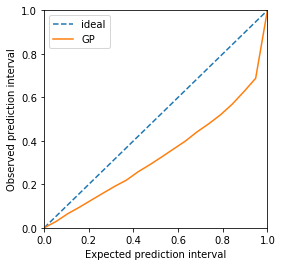

In [12]:
%matplotlib inline
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import seaborn as sns


# Plot the calibration curve
fig = plt.figure(figsize=(4, 4))
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label='GP')
_ = ax_gp.set_xlabel('Expected prediction interval')
_ = ax_gp.set_ylabel('Observed prediction interval')
_ = ax_gp.set_xlim([0, 1])
_ = ax_gp.set_ylim([0, 1])

# Report the calibration factor
actual_calibration_area = integrate.trapz(y=observed_pi, x=predicted_pi)
ideal_calibration_area = integrate.trapz(y=predicted_pi, x=predicted_pi)
calibration_factor = actual_calibration_area - ideal_calibration_area
print('Calibration factor = %.2f' % calibration_factor)

# Report sharpness
sharpness = np.sqrt(np.mean(standard_errors**2))
print('Sharpness = %.2f eV' % sharpness)
